# Initializing

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import TomekLinks

from imblearn.over_sampling import SMOTE, ADASYN
from typing import Iterable, Optional, Union
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.validation import check_is_fitted
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import (train_test_split, 
                                    RandomizedSearchCV, 
                                    StratifiedKFold)
from sklearn.metrics import recall_score
from sklearn.metrics import (classification_report, 
                            f1_score, 
                            confusion_matrix)
from collections import Counter


# Classes

In [43]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
#from imblearn.combine import TomekLinks
from typing import Optional, Literal

class FraudDetector(BaseEstimator, ClassifierMixin):

    def __init__(
        self,
        random_state: int = 39,
        n_jobs: Optional[int] = None,
        imbalance_strategy: Optional[Literal[
            "oversample", "undersample", "smote", "adasyn", "tomek", "class_weight", None
        ]] = None,
    ):
        """
        Fraud Detection model using RandomForestClassifier with optional
        imbalance handling techniques.

        Parameters
        ----------
        imbalance_strategy : {"oversample", "undersample", "smote", "adasyn", "tomek", "class_weight", None}, default=None
            Strategy for handling class imbalance:
                - "oversample": RandomOverSampler
                - "undersample": RandomUnderSampler
                - "smote": SMOTE
                - "adasyn": ADASYN
                - "tomek": Tomek Links
                - "class_weight": Use class_weight='balanced'
                - None: No resampling
        """
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.imbalance_strategy = imbalance_strategy

        # Internal model
        self._model_ = RandomForestClassifier(
            n_estimators=500,
            n_jobs=self.n_jobs,
            random_state=self.random_state,
        )

        # New attributes for resampled data
        self.X_resampled_ = None
        self.y_resampled_ = None

    def fit(self, X, y):
        # Handle imbalance
        if self.imbalance_strategy == "oversample":
            sampler = RandomOverSampler(random_state=self.random_state)
        elif self.imbalance_strategy == "undersample":
            sampler = RandomUnderSampler(random_state=self.random_state)
        elif self.imbalance_strategy == "smote":
            sampler = SMOTE(random_state=self.random_state)
        elif self.imbalance_strategy == "adasyn":
            sampler = ADASYN(random_state=self.random_state)
        elif self.imbalance_strategy == "tomek":
            sampler = TomekLinks()
        else:
            sampler = None

        if self.imbalance_strategy == "class_weight":
            self._model_.set_params(class_weight="balanced")

        # Apply resampling if sampler is defined
        if sampler is not None:
            X_resampled, y_resampled = sampler.fit_resample(X, y)
        else:
            X_resampled, y_resampled = X, y

        # Save the balanced data as attributes
        self.X_resampled_ = X_resampled
        self.y_resampled_ = y_resampled

        # Fit the model on balanced data
        self._model_.fit(X_resampled, y_resampled)
        return self

    def predict(self, X):
        return self._model_.predict(X)

    def predict_proba(self, X):
        return self._model_.predict_proba(X)



In [4]:
df = pd.read_csv('historical.csv')
df.head()

,tid,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,outcome
0,49b18cea-beb8-413d-b268-a0ec12a4147c,1.423808,-0.377568,0.242070,-0.697073,-0.763104,-0.731960,-0.367360,-0.278617,-0.996840,...,-0.469381,-0.810630,0.034175,-0.063592,0.252775,0.975686,-0.047713,0.008093,10.00,0
1,0d1de000-6756-4441-8133-e0ed75b72979,0.386691,1.932803,-1.958157,1.795148,0.597989,-1.752021,0.567382,0.225227,-0.614899,...,-0.037188,0.066752,0.232243,0.269168,-0.566513,-0.403250,0.151074,-0.044239,3.99,0
2,dc548f8c-ecd2-4fee-8a80-f2de7e2c7bd6,-0.822247,1.349695,-2.533342,-1.510371,2.429420,3.097419,-0.337696,1.778629,-0.306968,...,-0.280728,-0.954416,0.226719,0.589009,-0.325611,0.173346,0.110327,-0.006745,14.55,0
3,f105abf5-0c4c-4e79-9a8a-59de254e58dc,-0.679009,0.452323,1.256676,-1.163474,-0.871992,-0.413326,-0.319045,0.414021,-1.479641,...,0.171611,0.365879,-0.164711,0.366073,0.089739,-0.314979,-0.185542,-0.032110,10.00,0
4,164a2881-40c6-43ba-b53e-cd1e5a9e8cee,1.174152,-0.493073,-0.136508,-1.375827,-0.506841,-0.760343,0.066490,-0.174785,1.165490,...,-0.061790,-0.016600,-0.226672,0.107551,0.738778,-0.010159,-0.008166,0.006128,68.54,0


In [5]:
df = df.drop(columns = ['tid'])

# EDA

Our overall goal in the EDA is to guide the choice of preprocessing techniques. To do this, we will examine the extent of class imbalance and look for patterns that distinguish fraudulent from non-fraudulent transactions.

## Univariate

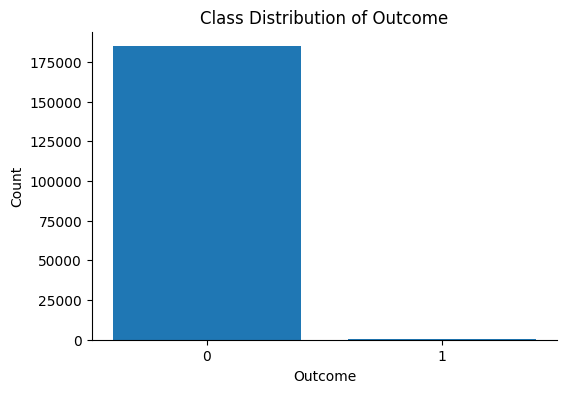

In [6]:
# Count values
class_counts = df["outcome"].value_counts().sort_index()

# Plot
plt.figure(figsize=(6,4))
plt.bar(class_counts.index.astype(str), class_counts.values)
plt.title("Class Distribution of Outcome")
plt.xlabel("Outcome")
plt.ylabel("Count")
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


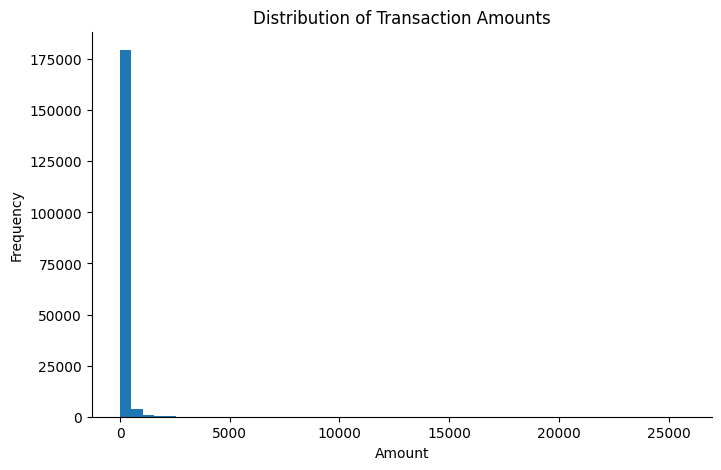

In [7]:
plt.figure(figsize=(8,5))
plt.hist(df["Amount"], bins=50)
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Amount")
plt.ylabel("Frequency")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


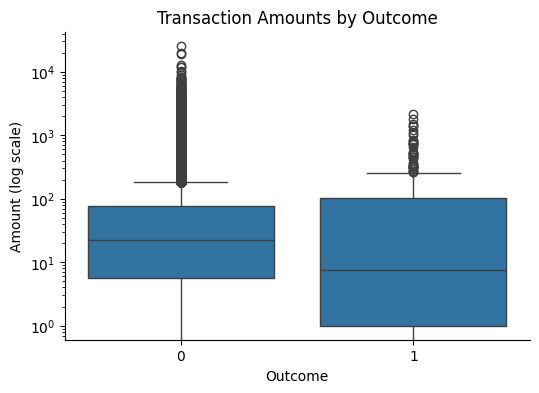

In [8]:
plt.figure(figsize=(6,4))

sns.boxplot(
    x="outcome",
    y="Amount",
    data=df
)
plt.yscale("log")  # handle skewness
plt.title("Transaction Amounts by Outcome")
plt.xlabel("Outcome")
plt.ylabel("Amount (log scale)")

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


## Bivariate

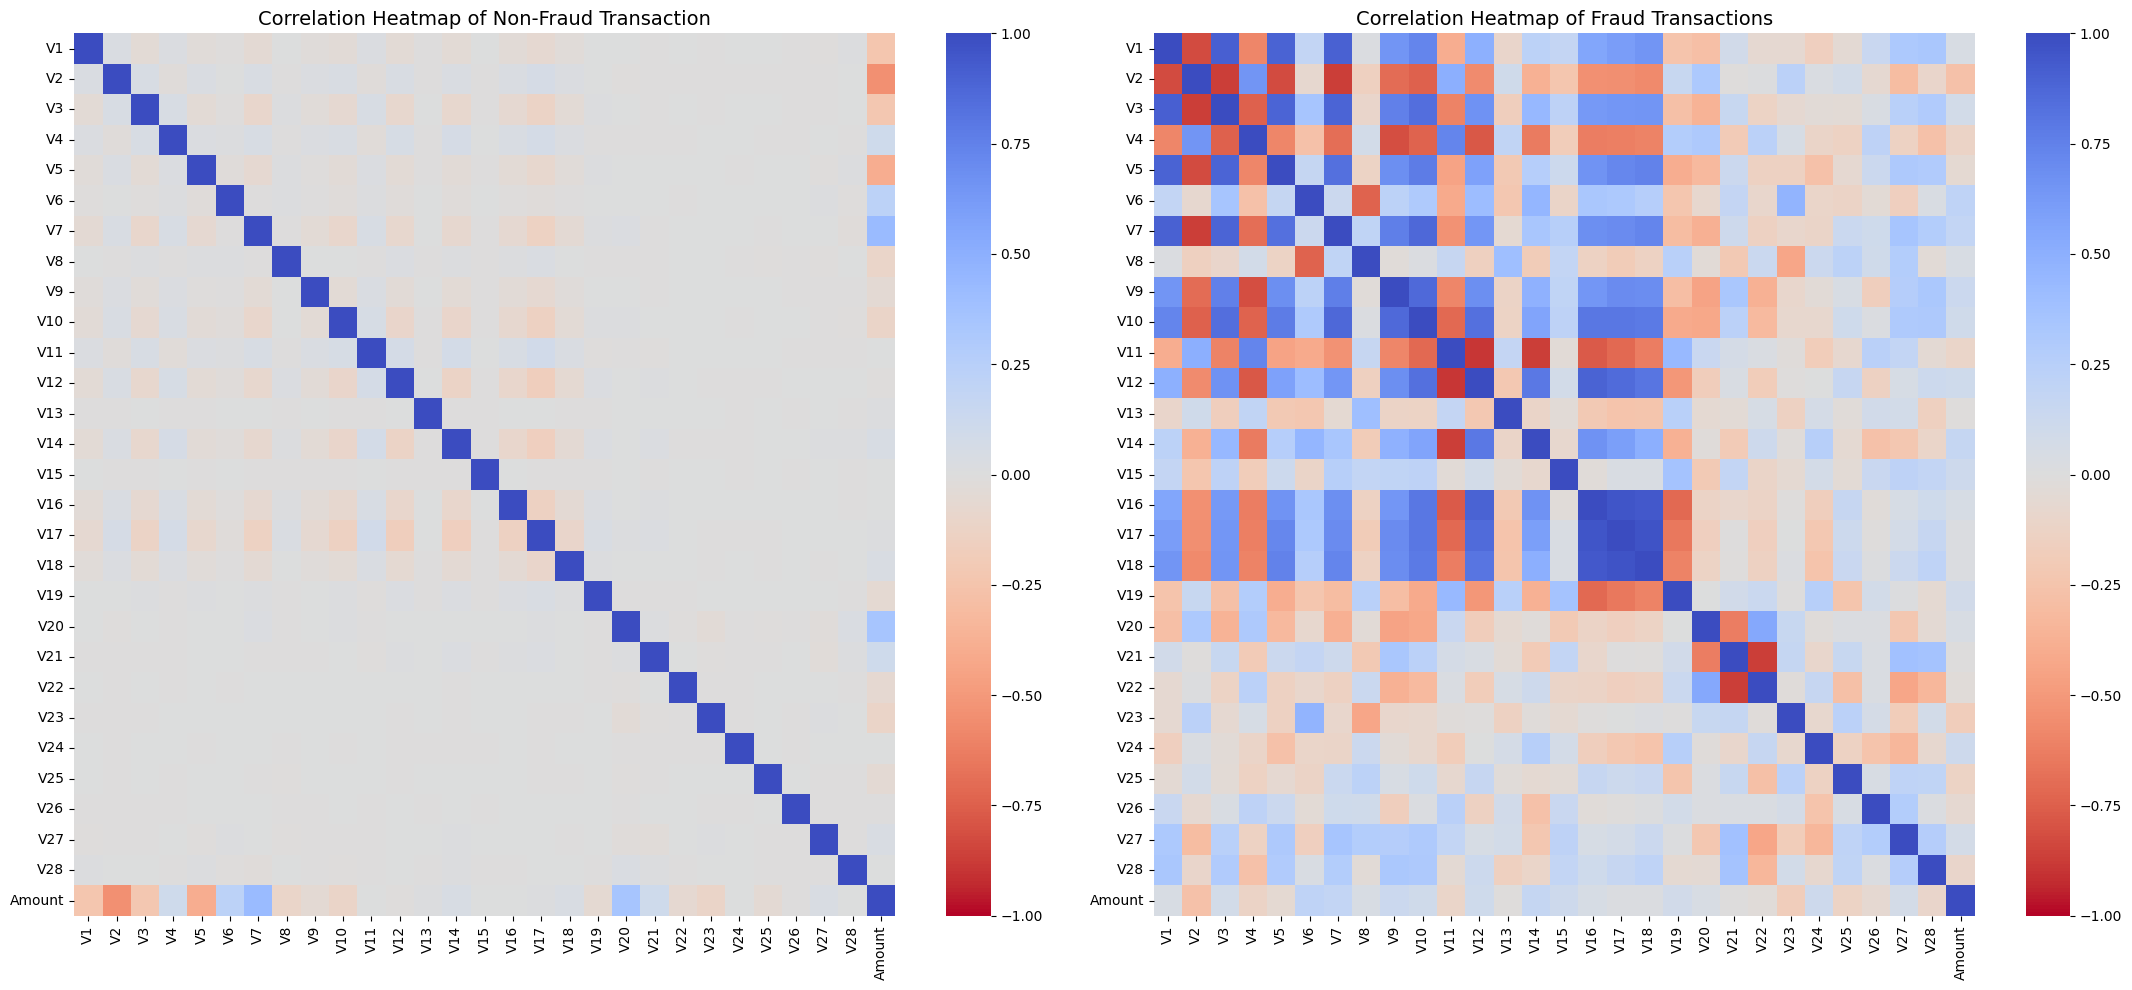

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Split datasets
is_fraud = df["outcome"] == 1
df_0 = df[~is_fraud]
df_1 = df[is_fraud]

# Compute correlation matrices
corr_0 = df_0.iloc[:, :-1].corr()
corr_1 = df_1.iloc[:, :-1].corr()

# Plot side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(22, 10))

sns.heatmap(
    corr_0,
    cmap="coolwarm_r",
    vmax=1,
    vmin=-1,
    center=0,
    annot=False,
    cbar=True,
    ax=axes[0]
)
axes[0].set_title("Correlation Heatmap of Non-Fraud Transaction", fontsize=14)

sns.heatmap(
    corr_1,
    cmap="coolwarm_r",
    vmax=1,
    vmin=-1,
    center=0,
    annot=False,
    cbar=True,
    ax=axes[1]
)
axes[1].set_title("Correlation Heatmap of Fraud Transactions", fontsize=14)

plt.tight_layout()
plt.show()

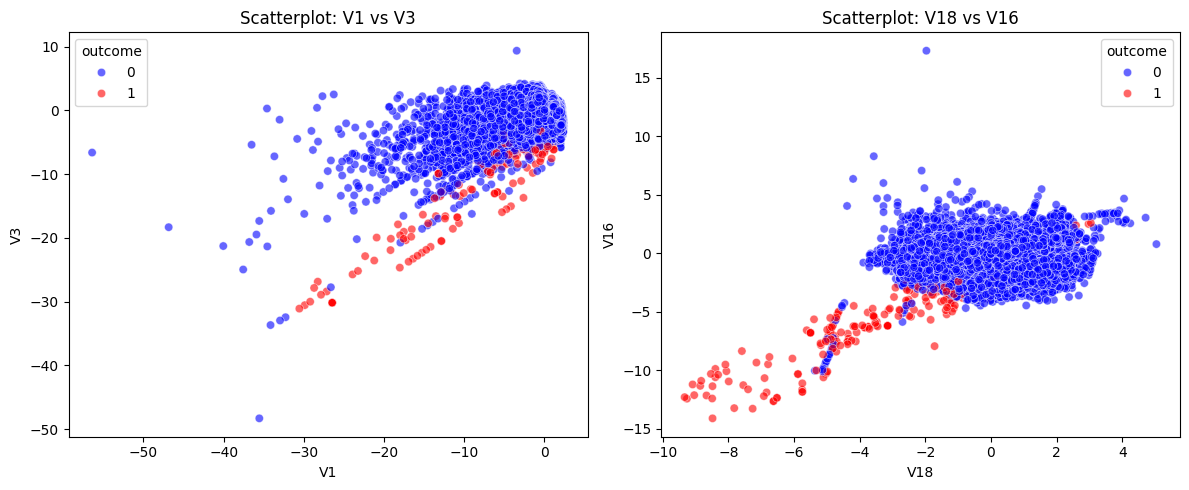

In [10]:
plt.figure(figsize=(12,5))

# V1 vs V3
plt.subplot(1,2,1)
sns.scatterplot(
    data=df,
    x="V1", y="V3",
    hue="outcome",
    alpha=0.6,
    palette={0: "blue", 1: "red"}
)
plt.title("Scatterplot: V1 vs V3")

# V18 vs V16
plt.subplot(1,2,2)
sns.scatterplot(
    data=df,
    x="V18", y="V16",
    hue="outcome",
    alpha=0.6,
    palette={0: "blue", 1: "red"}
)
plt.title("Scatterplot: V18 vs V16")

plt.tight_layout()
plt.show()

# Data Preprocessing

In [11]:
# Count of nulls per column
df.isnull().sum()

V1         0
V2         0
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
Amount     0
outcome    0
dtype: int64

In [12]:
df = df.dropna()

In [13]:
df.duplicated().sum()

4670

In [14]:
df_clean = df.drop_duplicates()

# Baseline

We use 3-way split

In [15]:
target = df["outcome"]

X, y = df.iloc[:, :-1], df.iloc[:, -1]

# Test set (Hold-out)
X_Train, X_test, y_Train, y_test = train_test_split(
    X, y, test_size=0.9, random_state=0, stratify=target
)

# Train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_Train, y_Train, test_size=0.2, random_state=0, stratify=y_Train
)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"X shape: {X.shape}")

X_train shape: (14809, 29)
X_val shape: (3703, 29)
X_test shape: (166612, 29)
X shape: (185124, 29)


In [16]:
# baseline_model = FraudDetector(imbalance_strategy=None)
# baseline_model.fit(X_train, y_train)

In [17]:
# from sklearn.metrics import f1_score, classification_report, confusion_matrix

# # ================= Baseline FraudDetector =================
# print("==========Baseline FraudDetector (No Imbalance Handling)==========")
# y_train_pred = baseline_model.predict(X_train)
# y_val_pred = baseline_model.predict(X_val)

# print(f"Training F1 Score: {f1_score(y_train, y_train_pred):.4f}")

# print("Validation Set Performance:\n", classification_report(y_val, y_val_pred))
# print("Validation Set Confusion Matrix:\n", 
#       pd.DataFrame(confusion_matrix(y_val, y_val_pred)))

In [18]:
# # ========= TUNED FRAUD DETECTOR (FAST) =========
# print("==========Tuned FraudDetector (FAST)==========")

# # Smaller parameter grid
# param_dist = {
#     "n_estimators": [100, 200],    # fewer trees
#     "max_depth": [None, 10, 20],   # smaller depth search
# }

# # Wrap the underlying RandomForest for tuning
# rf = RandomForestClassifier(random_state=39, n_jobs=-1)

# # Faster randomized search
# rs = RandomizedSearchCV(
#     rf,
#     param_distributions=param_dist,
#     n_iter=5,       # fewer random draws
#     scoring="f1",
#     cv=2,           # fewer folds
#     random_state=39,
#     n_jobs=-1,
#     verbose=1
# )

# # Fit search on training set
# rs.fit(X_train, y_train)

# # Best parameters
# best_rf_params = rs.best_params_
# print(f"Best Parameters: {best_rf_params}")

# # Build tuned FraudDetector with best params
# tuned_model = FraudDetector(imbalance_strategy=None)
# tuned_model._model_.set_params(**best_rf_params)

# # Fit tuned model
# tuned_model.fit(X_train, y_train)

# # Predictions
# y_train_pred_tuned = tuned_model.predict(X_train)
# y_val_pred_tuned = tuned_model.predict(X_val)

# # Scores
# print(f"Training F1 Score: {f1_score(y_train, y_train_pred_tuned):.4f}")
# print("Validation Set performance:\n", classification_report(y_val, y_val_pred_tuned))
# print("Validation Set Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_val, y_val_pred_tuned)))


# Handle Class Imbalance

In [19]:
from sklearn.model_selection import GridSearchCV

# Candidate values for n_estimators
param_grid = {
    "n_estimators": [100, 150, 200]
}

# Initialize FraudDetector with chosen imbalance strategy
base_model = FraudDetector(imbalance_strategy="oversample", random_state=39, n_jobs=-1)

# Use GridSearchCV on the internal RandomForest
grid = GridSearchCV(
    estimator=base_model._model_,  # access the RF inside FraudDetector
    param_grid=param_grid,
    scoring="f1",
    cv=2,
    n_jobs=-1
)

# Fit search
grid.fit(X_train, y_train)

print("Best n_estimators:", grid.best_params_["n_estimators"])
print("Best CV F1 score:", grid.best_score_)

# Update your FraudDetector with the tuned n_estimators
best_model = FraudDetector(
    imbalance_strategy="oversample",
    random_state=39,
    n_jobs=-1
)
best_model._model_.set_params(n_estimators=grid.best_params_["n_estimators"])
best_model.fit(X_train, y_train)

# Evaluate on validation
y_val_pred = best_model.predict(X_val)
print(classification_report(y_val, y_val_pred))

Best n_estimators: 200
Best CV F1 score: 0.7272727272727273
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3697
           1       0.67      0.67      0.67         6

    accuracy                           1.00      3703
   macro avg       0.83      0.83      0.83      3703
weighted avg       1.00      1.00      1.00      3703



In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    make_scorer,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
import pandas as pd

# ---------------------------
# Define scorers
# ---------------------------

# FCR: recall for fraud class (positive class)
fcr_scorer = make_scorer(recall_score, pos_label=1)

# Detection: macro recall
detection_scorer = make_scorer(recall_score, average="macro")

# Net value scorer (needs X, y, estimator)
def net_value_scorer(estimator, X, y):
    # Ensure X is a DataFrame
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
    y_pred = estimator.predict(X)
    amount = X.iloc[:, -1]  # last column as transaction value
    caught_value = amount[(y == 1) & (y_pred == 1)].sum()
    missed_value = amount[(y == 1) & (y_pred == 0)].sum()
    false_positive_value = amount[(y == 0) & (y_pred == 1)].sum()
    return caught_value - missed_value - false_positive_value

# Add f1 into scorers dict
scorers = {
    "f1": "f1",   # so refit="f1" works
    "fcr": fcr_scorer,
    "detection": detection_scorer,
    "net_value": net_value_scorer
}

# ---------------------------
# GridSearch + evaluation loop
# ---------------------------

# Candidate values for n_estimators
param_grid = {"n_estimators": [100, 150, 200]}

# All imbalance handling strategies to test
strategies = ["oversample", "undersample", "smote", "adasyn", "tomek", "class_weight"]

results = []

for strat in strategies:
    print("="*10, f"FraudDetector (imbalance_strategy={strat})", "="*10)
    
    # Initialize FraudDetector
    base_model = FraudDetector(imbalance_strategy=strat, random_state=39, n_jobs=-1)

    # Grid search with multiple scorers
    grid = GridSearchCV(
        estimator=base_model._model_,
        param_grid=param_grid,
        scoring=scorers,
        refit="f1",   # optimize on f1
        cv=2,
        n_jobs=-1,
        return_train_score=False
    )
    grid.fit(X_train, y_train)

    # Best tuned model
    best_model = FraudDetector(imbalance_strategy=strat, random_state=39, n_jobs=-1)
    best_model._model_.set_params(**grid.best_params_)
    best_model.fit(X_train, y_train)

    # Validation predictions
    y_val_pred = best_model.predict(X_val)

    # Metrics
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)

    # Pull avg FCR, detection, net value from cv_results_
    fcr = grid.cv_results_["mean_test_fcr"].mean()
    detection = grid.cv_results_["mean_test_detection"].mean()
    net_value = grid.cv_results_["mean_test_net_value"].mean()

    results.append({
        "Strategy": strat if strat else "baseline",
        "Best n_estimators": grid.best_params_["n_estimators"],
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "Avg FCR": fcr,
        "Avg Detection Rate": detection,
        "Avg Net Value": net_value
    })

# ---------------------------
# Summary Table
# ---------------------------
summary_df = pd.DataFrame(results)
print("\n=== Summary Table ===")
print(summary_df)


========== FraudDetector (imbalance_strategy=oversample) ==========
========== FraudDetector (imbalance_strategy=undersample) ==========
========== FraudDetector (imbalance_strategy=smote) ==========
========== FraudDetector (imbalance_strategy=adasyn) ==========
========== FraudDetector (imbalance_strategy=tomek) ==========
========== FraudDetector (imbalance_strategy=class_weight) ==========

=== Summary Table ===
       Strategy  Best n_estimators  Precision    Recall        F1   Avg FCR  \
0    oversample                150   0.950000  0.745098  0.835165  0.751095   
1   undersample                150   0.063014  0.901961  0.117798  0.751095   
2         smote                150   0.862745  0.862745  0.862745  0.751095   
3        adasyn                150   0.843137  0.843137  0.843137  0.751095   
4         tomek                150   0.926829  0.745098  0.826087  0.751095   
5  class_weight                150   0.945946  0.686275  0.795455  0.751095   

   Avg Detection Rate  Avg

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    make_scorer,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
)
import pandas as pd

# ---------------------------
# Define scorers
# ---------------------------

# FCR: recall for fraud class (positive class)
fcr_scorer = make_scorer(recall_score, pos_label=1)

# Detection: macro recall
detection_scorer = make_scorer(recall_score, average="macro")

# Net value scorer (needs X, y, estimator)
def net_value_scorer(estimator, X, y):
    # Ensure X is a DataFrame
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X)
    y_pred = estimator.predict(X)
    amount = X.iloc[:, -1]  # last column as transaction value
    caught_value = amount[(y == 1) & (y_pred == 1)].sum()
    missed_value = amount[(y == 1) & (y_pred == 0)].sum()
    false_positive_value = amount[(y == 0) & (y_pred == 1)].sum()
    return caught_value - missed_value - false_positive_value

# Add f1 into scorers dict
scorers = {
    "f1": "f1",   # so refit="f1" works
    "fcr": fcr_scorer,
    "detection": detection_scorer,
    "net_value": net_value_scorer
}

# ---------------------------
# GridSearch + evaluation loop
# ---------------------------

# Candidate values for n_estimators
param_grid = {"n_estimators": [150, 200]}

# All imbalance handling strategies to test
strategies = ["oversample", "undersample"]

results = []

for strat in strategies:
    print("="*10, f"FraudDetector (imbalance_strategy={strat})", "="*10)
    
    # Initialize FraudDetector
    base_model = FraudDetector(imbalance_strategy=strat, random_state=39, n_jobs=-1)

    base_model = base_model.fit(X_train, y_train)

    # Grid search with multiple scorers
    grid = GridSearchCV(
        estimator=base_model._model_,
        param_grid=param_grid,
        scoring=scorers,
        refit="f1",   # optimize on f1
        cv=2,
        n_jobs=-1,
        return_train_score=False
    )
    grid.fit(base_model.X_resampled_, base_model.y_resampled_)

    # Best tuned model
    best_model = FraudDetector(imbalance_strategy=strat, random_state=39, n_jobs=-1)
    best_model._model_.set_params(**grid.best_params_)
    best_model.fit(X_train, y_train)

    # Validation predictions
    y_val_pred = best_model.predict(X_val)

    # Metrics
    precision = precision_score(y_val, y_val_pred)
    recall = recall_score(y_val, y_val_pred)
    f1 = f1_score(y_val, y_val_pred)

    # Pull avg FCR, detection, net value from cv_results_
    fcr = grid.cv_results_["mean_test_fcr"].mean()
    print(grid.cv_results_["mean_test_fcr"])
    detection = grid.cv_results_["mean_test_detection"].mean()
    net_value = grid.cv_results_["mean_test_net_value"].mean()

    results.append({
        "Strategy": strat if strat else "baseline",
        "Best n_estimators": grid.best_params_["n_estimators"],
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "Avg FCR": fcr,
        "Avg Detection Rate": detection,
        "Avg Net Value": net_value
    })

# ---------------------------
# Summary Table
# ---------------------------
summary_df = pd.DataFrame(results)
print("\n=== Summary Table ===")
print(summary_df)


========== FraudDetector (imbalance_strategy=oversample) ==========
[1. 1.]
========== FraudDetector (imbalance_strategy=undersample) ==========
[0.96153846 0.96153846]

=== Summary Table ===
      Strategy  Best n_estimators  Precision    Recall        F1   Avg FCR  \
0   oversample                150   0.666667  0.666667  0.666667  1.000000   
1  undersample                150   0.294118  0.833333  0.434783  0.961538   

   Avg Detection Rate  Avg Net Value  
0            0.999966     1211337.99  
1            0.961538        1024.74  


In [23]:
results

[{'Strategy': 'oversample',
  'Best n_estimators': 200,
  'Precision': 0.6666666666666666,
  'Recall': 0.6666666666666666,
  'F1': 0.6666666666666666,
  'Avg FCR': 0.5961538461538461,
  'Avg Detection Rate': 0.7980092778084,
  'Avg Net Value': 18.984999999999992},
 {'Strategy': 'undersample',
  'Best n_estimators': 200,
  'Precision': 0.2777777777777778,
  'Recall': 0.8333333333333334,
  'F1': 0.4166666666666667,
  'Avg FCR': 0.5961538461538461,
  'Avg Detection Rate': 0.7980092778084,
  'Avg Net Value': 18.984999999999992}]

# Modeling

# Using Test.csv

Please use the test.csv file and include the output based on our model and export it in a csv file